# Main imports and code

In [1]:
import pandas as pd
import logging
import torch
import os
from sklearn.metrics import accuracy_score, f1_score
from preprocessing import load_data, preprocess_data, DPMDataset, augment_data
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from transformers import DebertaPreTrainedModel, RobertaPreTrainedModel, BertPreTrainedModel,ElectraPreTrainedModel, DebertaModel, BertModel, ElectraModel, RobertaModel
from transformers import Trainer, TrainingArguments, AutoTokenizer
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
from torch.optim import lr_scheduler


os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["WANDB_DISABLED"] = "true"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"


In [2]:
# prepare logger
logging.basicConfig(level=logging.INFO)

transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# check gpu
cuda_available = torch.cuda.is_available()
device = "cuda" if torch.cuda.is_available() else "cpu"


print('Cuda available? ',cuda_available)

Cuda available?  True


In [3]:
torch.cuda.set_device(2)

In [4]:
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/infres/hverninas-22/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/infres/hverninas-22/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [5]:
train_df, dev_df, test_df = load_data()

In [6]:
train_df = preprocess_data(train_df)
dev_df = preprocess_data(dev_df)
test_df = preprocess_data(test_df)

# RoBERTa Baseline for Task 1

In [7]:
augmented_df = augment_data(train_df)

In [8]:
augmented_data = pd.read_csv("data/generated_pcl4_data.txt", sep='\t')
augmented_data = preprocess_data(augmented_data)

In [9]:
training_set = pd.concat([train_df[['text', 'label']],augmented_data[["text","label"]]])


In [10]:
training_set

,text,label
0,The scheme saw estimated children poor familie...,1
1,Durban homeless communities reconciliation lunch,1
2,The next immediate problem cropped assist unfo...,1
3,Far important implications Economy Gods dollar...,1
4,To strengthen social protection systems includ...,1
...,...,...
2053,Amidst crumbling shelters haunting silence bar...,1
2054,As gather yet another opulent gala seems tragi...,1
2055,It astonishing many people fail recognize fund...,1
2056,It truly warms heart consider making small don...,1


In [64]:
class DebertaClassification(RobertaPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.model = RobertaModel(config)
        self.projection = nn.Sequential(
            nn.Linear(config.hidden_size, 1),
            nn.Sigmoid()
        )
        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        inputs_embeds=None,
        target=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None):
        
        model_output = self.model(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )[0][:,0,:]  # Shape: (batch_size, seq_length, hidden_size)
        
        logits = self.projection(model_output)  # Projection layer
        return logits


In [44]:
# Code for evaluating model performance 
def predict_PCL(input, tokenizer, model, country=None):
  
  model.eval()
  encodings = tokenizer(input, return_tensors='pt', padding=True, truncation=True, max_length=256).to(device)
  output = model(**encodings).squeeze()
  preds = torch.round(output).int()

  return {'prediction':preds, 'confidence':output}


In [ ]:
class Trainer_PCL(Trainer):

    def __init__( 
        self,
        criterion=None,
        logging=False,
        **kwargs
        ):

        super().__init__(**kwargs)
        
        self.step = 0
        self.logging_step = 100
        self.results = {"train": {}, "eval": {}}  # Store train and eval metrics per epoch
        self.criterion = criterion
        self.logging = logging


    def compute_loss(self, model, inputs, num_items_in_batch=None):
        if self.criterion is not None:
            criterion = self.criterion
        else:
            criterion = torch.nn.MSELoss()

        outputs = model(**inputs)

        target = inputs['target'].float()
        loss = criterion(outputs.view(-1), target)
         

        if self.logging and self.step % self.logging_step == 0:
            pred = torch.round(outputs.view(-1)).int().detach().cpu()
            label = target.cpu()
            train_accuracy = accuracy_score(label,pred)
            train_f1 = f1_score(label,pred)
            self.results["train"][self.step] = {"loss": loss.item(), "accuracy": train_accuracy, "f1": train_f1}
            self.log({"train_loss": loss.item(), "train_accuracy": train_accuracy})

            
            eval_dataloader = super().get_test_dataloader(self.eval_dataset)
            self.model.eval()
            with torch.no_grad():
                preds = []
                labels = []
                for data in eval_dataloader:
                    output = self.model(**data)
                    pred = torch.round(output.view(-1)).int().detach().cpu()
                    preds.extend(pred.tolist())
                    labels.extend(data['target'].cpu().tolist())
                eval_accuracy = accuracy_score(labels,preds)
                eval_f1 = f1_score(labels,preds)
                self.results["eval"][self.step] = {"accuracy": eval_accuracy, "f1": eval_f1}


        self.step += 1
        return loss
    
    def get_train_dataloader(self):
        labels = self.train_dataset.label
        class_counts = np.bincount(labels)
        class_weights = len(labels) / class_counts
        sample_weights = np.array([class_weights[label] for label in labels])

        sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

        return DataLoader(
            self.train_dataset,
            batch_size=self.args.per_device_train_batch_size,
            sampler=sampler,
            collate_fn=self.data_collator,
        )
    
    def evaluate(self, eval_dataset=None, ignore_keys=None, metric_key_prefix='eval'):
        if self.epoch < 10:
            self.epoch += 1
            return
        
        preds = []
        labels = []

        eval_dataloader = super().get_test_dataloader(self.eval_dataset)
        self.model.eval()
        with torch.no_grad():
            for data in tqdm(eval_dataloader):
                output = self.model(**data)
                pred = torch.max(output, 1)[1]
            
                preds.extend(pred.cpu().tolist())
                labels.extend(data['target'].cpu().tolist())

        metrics = compute_metrics((preds, labels))
        print(metrics)
        self.log(metrics)

        self.results["eval"][self.epoch] = metrics
        self.epoch += 1       


def compute_metrics(eval_pred):
    preds, labels = eval_pred

    report = classification_report(preds, labels, target_names=["Not PCL","PCL"], output_dict=True)
    accuracy = accuracy_score(labels, preds)

    return {
        "accuracy": accuracy,
        "f1": report['PCL']['f1-score'],
        "precision": report['PCL']['precision'],
        "recall": report['PCL']['recall']
    }


def train(model, train_data, eval_data, num_epochs, tokenizer, lr=0.0001, optimizer=None, lr_scheduler=None, criterion=None, logging=True):
    train_data = train_data.reset_index(drop=True)
    eval_data = eval_data.reset_index(drop=True)

    train_dataset = DPMDataset(train_data, tokenizer, max_len=256)
    eval_dataset = DPMDataset(eval_data, tokenizer, max_len=256)

    Training_args = TrainingArguments(
        output_dir="test_trainer",
        learning_rate=lr,
        logging_steps=50,
        per_device_train_batch_size=4,
        num_train_epochs=num_epochs,
        remove_unused_columns=False,
        logging_dir='./logs', 
        report_to="all",
    )
    
    trainer = Trainer_PCL(
        criterion=criterion,
        model=model,
        args=Training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        data_collator=train_dataset.collate_fn,
        optimizers=(optimizer, lr_scheduler),
        logging=logging,
    )
    
    trainer.train()
    trainer.save_model('model-finetuned')
    return trainer.results


In [46]:
def evaluate(model, tokenizer, data_loader, score=True):

  preds = []
  tot_labels = []
  outputs = []

  with torch.no_grad():
    
    for data in tqdm(data_loader):

      text = data['text']
      # country = data['country'].float()
      pred = predict_PCL(text, tokenizer, model)

      preds.append(pred['prediction'].tolist())
      outputs.append(pred['confidence'].tolist())
      if score:
        tot_labels.append(data['target'].tolist()[0])

  if score:
    print(preds)
    print(outputs)
    print(tot_labels)
    print("f1 score:", f1_score(tot_labels,preds))
    # with the saved predictions and labels we can compute accuracy, precision, recall and f1-score
    print(classification_report(tot_labels, preds, target_names=["Not PCL","PCL"]))

  return preds


In [65]:
def get_optimizer(model, base_lr=5e-5, lr_lambda=1.6):
    """
    Implements Layer-wise Learning Rate Decay.
    - base_lr: The learning rate for the last layer.
    - lr_decay_rate: Rate at which the learning rate decays for earlier layers.
    """
    optimizer_params = []

    layer_names = [name for name,_ in model.model.named_parameters()]
    weights = []
    for name in layer_names:
        name_split = name.split('.')
        if len(name_split)>2 and name_split[2].isdigit():
            layer_number =  int(name.split('.')[2])
        elif len(weights)>0:
            layer_number = weights[-1]
        else:
            layer_number=0
        weights.append(layer_number)
    weights = np.array(weights)
    split_size = len(weights)//3
    weights[:] = 1
    weights[:split_size] = 1/lr_lambda
    weights[len(weights)-split_size-1:] = lr_lambda


    # For the model layers
    for weight, (name, param) in zip(weights,model.model.named_parameters()):
        # Decide which layer it is
        
        lr = base_lr * weight  # Apply decay to earlier layers

        optimizer_params.append({'params': param, 'lr': lr})

    # For the classifier head (higher learning rate)
    for name, param in model.projection.named_parameters():
        optimizer_params.append({'params': param, 'lr': base_lr})

    optimizer = torch.optim.AdamW(optimizer_params,  lr=base_lr, weight_decay=0.01)

    return optimizer


In [69]:

model = DebertaClassification.from_pretrained('FacebookAI/roberta-large')
# model = DebertaClassification.from_pretrained('microsoft/deberta-base')
# model = DebertaClassification.from_pretrained('microsoft/deberta-base')

tokenizer = AutoTokenizer.from_pretrained('FacebookAI/roberta-large')

criterion = torch.nn.BCELoss()

lr = 1e-4
optimizer = get_optimizer(model, base_lr=lr, lr_lambda=1.6)
lrs = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# training_df, eval_df = train_test_split(augmented_df, test_size=0.2)

results = train(model, augmented_df, dev_df, num_epochs=3, tokenizer=tokenizer, lr=lr, lr_scheduler=lrs, optimizer=optimizer, criterion=criterion, logging=False)

Some weights of DebertaClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['roberta.model.embeddings.LayerNorm.bias', 'roberta.model.embeddings.LayerNorm.weight', 'roberta.model.embeddings.position_embeddings.weight', 'roberta.model.embeddings.token_type_embeddings.weight', 'roberta.model.embeddings.word_embeddings.weight', 'roberta.model.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.model.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.model.encoder.layer.0.attention.output.dense.bias', 'roberta.model.encoder.layer.0.attention.output.dense.weight', 'roberta.model.encoder.layer.0.attention.self.key.bias', 'roberta.model.encoder.layer.0.attention.self.key.weight', 'roberta.model.encoder.layer.0.attention.self.query.bias', 'roberta.model.encoder.layer.0.attention.self.query.weight', 'roberta.model.encoder.layer.0.attention.self.value.bias', 'roberta.model.encoder.layer.0.attention.self.value.weigh

Step,Training Loss
50,0.927300
100,0.723200
150,0.819700
200,0.764100
250,0.825800
300,0.735600
350,0.730900
400,0.703300
450,0.775500
500,0.706400


KeyboardInterrupt: 

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_results(results):
    """
    Plots train & evaluation accuracy and F1-score over epochs.
    """
    if not results:
        print("No results found.")
        return

    # Convert results dictionary into DataFrame
    train_metrics = pd.DataFrame(results["train"]).T  # Convert train results to DataFrame (transpose for epoch-wise view)
    eval_metrics = pd.DataFrame(results["eval"]).T  # Convert eval results to DataFrame (transpose for epoch-wise view)

    epochs = train_metrics.index.astype(int)  # Convert index to integer epochs

    # Set up the plot style
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))

    # Plot Train and Eval Accuracy
    plt.plot(epochs, train_metrics["accuracy"], label="Train Accuracy", linestyle='--', color='blue')
    plt.plot(epochs, eval_metrics["accuracy"], label="Eval Accuracy", linestyle='--', color='red')

    # Plot Train and Eval F1-score
    plt.plot(epochs, train_metrics["f1"], label="Train F1-score", linestyle='-', color='blue')
    plt.plot(epochs, eval_metrics["f1"], label="Eval F1-score", linestyle='-', color='red')

    # Labels and Legends
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title("Training & Evaluation Metrics Over Epochs")
    plt.legend()
    plt.show()

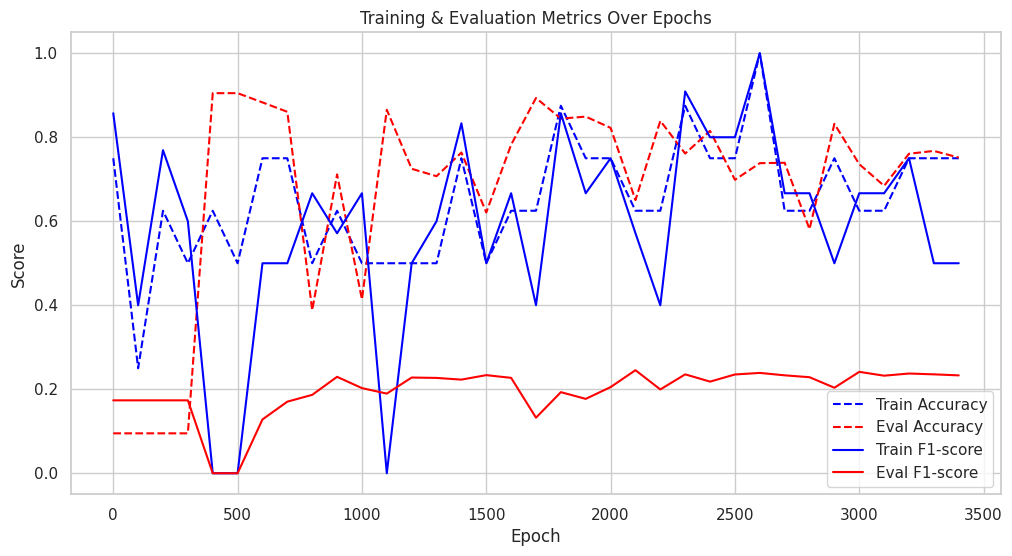

In [67]:
plot_results(results)

In [63]:
test_dataset = DPMDataset(dev_df, tokenizer, 256)
test_loader = DataLoader(test_dataset, shuffle=False)

preds = evaluate(model, tokenizer, test_loader)

100%|██████████| 2094/2094 [00:27<00:00, 75.70it/s]

[1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 